In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from voting_schemes import *
from happiness_measure import *
from risk_measure import *
from ATVA3_visualize import ATVA3

In [2]:
# helper functions
def convert_to_numerical(matrix, mapping):
    return np.array([[mapping[char] for char in row] for row in matrix], dtype=int)

def convert_to_rankings(leaderboard):
    rankings = {item: len(leaderboard) - i for i, item in enumerate(leaderboard)}
    return [rankings[item] for item in leaderboard]

In [3]:
# voter_preference = np.char.array(
#         # voters:   1    2    3    4    5    6
#         [
#             ["B", "A", "D", "E", "E", "D", "B"],  # 1st preference
#             ["C", "C", "E", "D", "D", "A", "A"],  # 2nd preference
#             ["A", "E", "A", "A", "A", "C", "E"],  # 3rd preference
#             ["D", "B", "C", "B", "B", "E", "D"],  # 4th preference
#             ["E", "D", "B", "C", "C", "B", "C"],
#         ]  
#     )

voter_preference = np.char.array([
    # voters: 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20
    ["B", "A", "D", "E", "E", "D", "B", "C", "A", "B", "E", "A", "D", "B", "C", "E", "A", "D", "B", "C"],  # 1st preference
    ["C", "C", "E", "D", "D", "A", "A", "E", "B", "D", "A", "B", "E", "A", "E", "B", "C", "B", "E", "A"],  # 2nd preference
    ["A", "E", "A", "A", "A", "C", "E", "B", "E", "A", "B", "E", "A", "E", "B", "A", "E", "A", "C", "E"],  # 3rd preference
    ["D", "B", "C", "B", "B", "E", "D", "A", "C", "E", "C", "C", "B", "C", "A", "D", "B", "E", "A", "B"],  # 4th preference
    ["E", "D", "B", "C", "C", "B", "C", "D", "D", "C", "D", "D", "C", "D", "D", "C", "D", "C", "D", "D"]   # 5th preference
])

# voter_preference = np.char.array([
#     # voters:  1   2   3   4   5   6   7   8   9   10  
#     ["B", "A", "D", "E", "E", "G", "G", "C", "A", "B"],  # 1st preference
#     ["C", "C", "E", "G", "D", "A", "F", "E", "B", "D"],  # 2nd preference
#     ["A", "G", "F", "A", "F", "C", "E", "F", "G", "F"],  # 3rd preference
#     ["D", "B", "C", "B", "G", "E", "D", "A", "F", "E"],  # 4th preference
#     ["E", "D", "B", "F", "C", "B", "C", "D", "D", "C"],  # 5th preference
#     ["F", "E", "A", "D", "A", "D", "A", "G", "C", "G"],  # 6th preference
#     ["G", "F", "G", "C", "B", "F", "B", "B", "E", "A"]   # 7th preference
# ])

# voter_preference = np.char.array([
#     # voters:  1   2   3   4   5   6   7
#     ["B", "A", "D", "E", "E", "G", "G"],  # 1st preference
#     ["C", "C", "H", "H", "D", "A", "F"],  # 2nd preference
#     ["A", "G", "F", "A", "F", "C", "E"],  # 3rd preference
#     ["H", "B", "C", "B", "G", "E", "D"],  # 4th preference
#     ["E", "D", "B", "F", "C", "H", "C"],  # 5th preference
#     ["F", "E", "A", "D", "H", "D", "A"],  # 6th preference
#     ["G", "H", "G", "C", "B", "F", "B"],   # 7th preference
#     ["D", "F", "E", "G", "A", "B", "H"]   # 8th preference
# ])

candidate_mapping = {candidate: idx + 1 for idx, candidate in enumerate(sorted(np.unique(voter_preference)))}
m, n = voter_preference.shape

In [4]:
lin_weights = np.linspace(1, 0.1, m).tolist()
exp_weights = np.logspace(0, np.log10(0.1), m).tolist()
voting_schemes = [plurality_voting, anti_plurality_voting, borda_count_voting, two_person_voting]
happiness_measures = [NDCG, BubbleSortDistance, KendallTau]
risk_measures = [NaivePSV, HappinessWeightedPSV, FlipRewardRisk, WinnerChangeRisk]

In [5]:
# Simulation parameters
num_experiments = 200
params = {
    'num_simulations': 1000,
    'window_size': 50,
    'stable_window': 100,
    'target_acceptance': 0.2,
    'improvement_threshold': 0.01
}

In [6]:
overall = []

for happ in happiness_measures:
    for risk in risk_measures:
        print(f"\nEval. Measurements - happiness: {happ.__name__}, risk: {risk.__name__}")
        print(20 * "_", "\n")
        
        # if risk.__name__ in ['BubbleSortDistance', 'KendallTau']:
        #     analyzer = ATVA3(
        #         happiness_measure=happ,
        #         risk_measure=risk(preferenceWeights=lin_weights)
        #     )
        # else:
        #     analyzer = ATVA3(
        #         happiness_measure=happ,
        #         risk_measure=risk
        #     )
        
        analyzer = ATVA3(
            happiness_measure=happ,
            risk_measure=risk
        )
        
        combination = []
        print("Simulating...")
        for scheme in voting_schemes:
            print(f"    {scheme.__name__}")
            true_outcome = scheme(voter_preference=voter_preference)
            true_outcome = {k: v for k, v in sorted(true_outcome.items(), key=lambda item: item[1], reverse=True)}
            results = []
            
            start = datetime.now()
            for i in range(num_experiments):
                
                reconstruct_preference, reconstruct_outcome, individual_happiness, overall_happiness, _, risk_value, stability = analyzer.analyze(
                    voter_preference=voter_preference,
                    voting_scheme=scheme,
                    sim_params=params
                )

                if reconstruct_preference.size == 0:
                    continue

                
                results.append({
                    'experiment_id': i,
                    'true_outcome': true_outcome,
                    'reconstruct_preference': reconstruct_preference,
                    'reconstruct_outcome': reconstruct_outcome,
                    'individual_happiness': individual_happiness,
                    'overall_happiness': overall_happiness,
                    'risk': risk_value,
                    'stability': stability
                })
            
            combination.append({
                'happiness': happ.__name__,
                'risk': risk.__name__,
                'scheme': scheme.__name__.replace('_', ' ').title(),
                'results': results
            })
            end = datetime.now()
            runtime = (end - start).total_seconds()
            print(f"    Runtime: {runtime}\n")
        
        overall.append(combination)


Eval. Measurements - happiness: NDCG, risk: NaivePSV
____________________ 

Simulating...
    plurality_voting
    Runtime: 20.790439

    anti_plurality_voting
    Runtime: 30.14458

    borda_count_voting
    Runtime: 22.861252

    two_person_voting
    Runtime: 20.437716


Eval. Measurements - happiness: NDCG, risk: HappinessWeightedPSV
____________________ 

Simulating...
    plurality_voting
    Runtime: 22.160888

    anti_plurality_voting
    Runtime: 30.278071

    borda_count_voting
    Runtime: 23.073279

    two_person_voting
    Runtime: 20.982657


Eval. Measurements - happiness: NDCG, risk: FlipRewardRisk
____________________ 

Simulating...
    plurality_voting
    Runtime: 21.561415

    anti_plurality_voting
    Runtime: 30.545415

    borda_count_voting
    Runtime: 22.887096

    two_person_voting
    Runtime: 20.378561


Eval. Measurements - happiness: NDCG, risk: WinnerChangeRisk
____________________ 

Simulating...
    plurality_voting
    Runtime: 21.705482

  

In [7]:
# Flatten the nested structure for easier analysis
flattened_data = []
for i, combinations in enumerate(overall):
    for combo in combinations:
        for result in combo['results']:
            # similarity between preferences 
            vp_numerical = convert_to_numerical(voter_preference, candidate_mapping).flatten().reshape(1, -1)
            rp_numerical = convert_to_numerical(result['reconstruct_preference'], candidate_mapping).flatten().reshape(1, -1)
            similarity_pref = cosine_similarity(vp_numerical, rp_numerical)[0][0]

            # similarity between true_outcome and reconstruct_outcome
            true_leaderboard = [item[0] for item in sorted(result['true_outcome'].items(), key=lambda x: x[1], reverse=True)]
            recon_leaderboard = [item[0] for item in sorted(result['reconstruct_outcome'].items(), key=lambda x: x[1], reverse=True)]

            true_rankings = np.array(convert_to_rankings(true_leaderboard)).reshape(1,-1)
            recon_rankings = np.array(convert_to_rankings(recon_leaderboard)).reshape(1,-1)
            similarity_leader = cosine_similarity(true_rankings, recon_rankings)[0][0]
            
            flattened_data.append({
                'happiness_measure': combo['happiness'],
                'risk_measure': combo['risk'],
                'voting_scheme': combo['scheme'],
                'true_outcome': result['true_outcome'],
                'reconstruct_preference': result['reconstruct_preference'],
                'reconstruct_outcome': result['reconstruct_outcome'],
                'pref_similarity': similarity_pref,
                'outcome_similarity': similarity_leader,
                'ind_happiness_mean': np.mean(result['individual_happiness']),
                'ind_happiness_variation': (np.std(result['individual_happiness'], ddof=1) / np.mean(result['individual_happiness'])),
                'ind_happiness_min': np.min(result['individual_happiness']),
                'ind_happiness_max': np.max(result['individual_happiness']),
                'risk': result['risk']
            })
experiments_df = pd.DataFrame(flattened_data)

In [8]:
experiments_df.tail()

,happiness_measure,risk_measure,voting_scheme,true_outcome,reconstruct_preference,reconstruct_outcome,pref_similarity,outcome_similarity,ind_happiness_mean,ind_happiness_variation,ind_happiness_min,ind_happiness_max,risk
9595,KendallTau,WinnerChangeRisk,Two Person Voting,"{'A': 9, 'B': 9, 'E': 9, 'D': 7, 'C': 6}","[[D, B, A, C, C, D, B, B, E, D, B, C, E, E, A,...","{'A': 10, 'B': 10, 'E': 8, 'D': 7, 'C': 5}",0.788182,1.0,0.21,0.899536,0.0,0.6,0.413793
9596,KendallTau,WinnerChangeRisk,Two Person Voting,"{'A': 9, 'B': 9, 'E': 9, 'D': 7, 'C': 6}","[[A, C, A, E, B, E, B, D, C, D, C, A, B, E, A,...","{'A': 10, 'B': 9, 'E': 8, 'D': 7, 'C': 6}",0.816364,1.0,0.28,0.848326,0.0,1.0,0.134078
9597,KendallTau,WinnerChangeRisk,Two Person Voting,"{'A': 9, 'B': 9, 'E': 9, 'D': 7, 'C': 6}","[[D, A, D, E, B, B, A, C, A, D, B, E, E, E, C,...","{'A': 9, 'B': 9, 'E': 9, 'D': 7, 'C': 6}",0.851818,1.0,0.19,1.386204,0.0,1.0,0.354680
9598,KendallTau,WinnerChangeRisk,Two Person Voting,"{'A': 9, 'B': 9, 'E': 9, 'D': 7, 'C': 6}","[[E, A, B, B, D, E, B, C, A, D, E, B, B, A, A,...","{'A': 11, 'B': 8, 'E': 8, 'D': 7, 'C': 6}",0.856364,1.0,0.24,0.880258,0.0,0.6,0.000000
9599,KendallTau,WinnerChangeRisk,Two Person Voting,"{'A': 9, 'B': 9, 'E': 9, 'D': 7, 'C': 6}","[[C, A, B, C, E, A, B, D, A, A, E, E, D, A, D,...","{'A': 11, 'B': 8, 'E': 8, 'D': 7, 'C': 6}",0.867273,1.0,0.24,0.920844,0.0,0.6,0.000000


## 5. Statistics

In [10]:
from itertools import permutations

risks = {}

for risk in risk_measures:
    risk_name = risk.__name__
    if risk_name not in risks:
        risks[risk_name] = {}

    for happ in happiness_measures:
        happ_name = happ.__name__
        if happ_name not in risks[risk_name]:
            risks[risk_name][happ_name] = {}

        for scheme in voting_schemes:
            # Map scheme functions to readable names
            scheme_map = {
                "plurality_voting": "Plurality Voting",
                "anti_plurality_voting": "Anti Plurality Voting",
                "borda_count_voting": "Borda Count Voting",
                "two_person_voting": "Two Person Voting"
            }
            scheme_name = scheme.__name__
            name = scheme_map.get(scheme_name, None)

            if name is None:
                continue  # Skip if scheme is not recognized

            # Compute true outcome
            outcome = scheme(voter_preference)  
            true_winner = min(outcome.items(), key=lambda x: (-x[1], x[0]))[0]
            outcome = {k: v for k, v in sorted(outcome.items(), key=lambda item: item[1], reverse=True)}

            # Calculate individual happiness
            individual_happiness = [
                happ(voter_preference[:, i], list(outcome.keys()))
                for i in range(n)
            ]

            strategic_options = []
            for i in range(n):
                options = set()
                mod_pref = voter_preference.copy()
                all_options = set(permutations(voter_preference[:, i]))
                all_options.discard(
                    tuple(voter_preference[:, i])
                )
                
                for option in all_options:
                    # Modify preferences and check outcome
                    mod_pref[:, i] = option
                    mod_outcome = scheme(mod_pref)
                    mod_outcome = {k: v for k, v in sorted(mod_outcome.items(), key=lambda item: item[1], reverse=True)}

                    # Compute modified happiness
                    mod_happiness = happ(voter_preference[:, i], list(mod_outcome.keys()))
                    #if mod_happiness > individual_happiness[i]:
                    options.add((tuple(option), mod_happiness))  # Ensure hashability
                strategic_options.append(options)

            # Compute risk score
            risk_score = risk(voter_preference, scheme, individual_happiness, strategic_options)
            

            # Assign computed risk score
            risks[risk_name][happ_name][name] = risk_score
risks

{'NaivePSV': {'NDCG': {'Plurality Voting': 0.45,
   'Anti Plurality Voting': 0.35,
   'Borda Count Voting': 0.15,
   'Two Person Voting': 0.35},
  'BubbleSortDistance': {'Plurality Voting': 0.2,
   'Anti Plurality Voting': 0.35,
   'Borda Count Voting': 0.25,
   'Two Person Voting': 0.3},
  'KendallTau': {'Plurality Voting': 0.65,
   'Anti Plurality Voting': 0.45,
   'Borda Count Voting': 0.45,
   'Two Person Voting': 0.3}},
 'HappinessWeightedPSV': {'NDCG': {'Plurality Voting': np.float64(0.12100840336134452),
   'Anti Plurality Voting': np.float64(0.07058823529411765),
   'Borda Count Voting': np.float64(0.0075630252100840345),
   'Two Person Voting': np.float64(0.07563025210084034)},
  'BubbleSortDistance': {'Plurality Voting': np.float64(0.040336134453781515),
   'Anti Plurality Voting': np.float64(0.07058823529411765),
   'Borda Count Voting': np.float64(0.011764705882352941),
   'Two Person Voting': np.float64(0.055462184873949584)},
  'KendallTau': {'Plurality Voting': np.float6

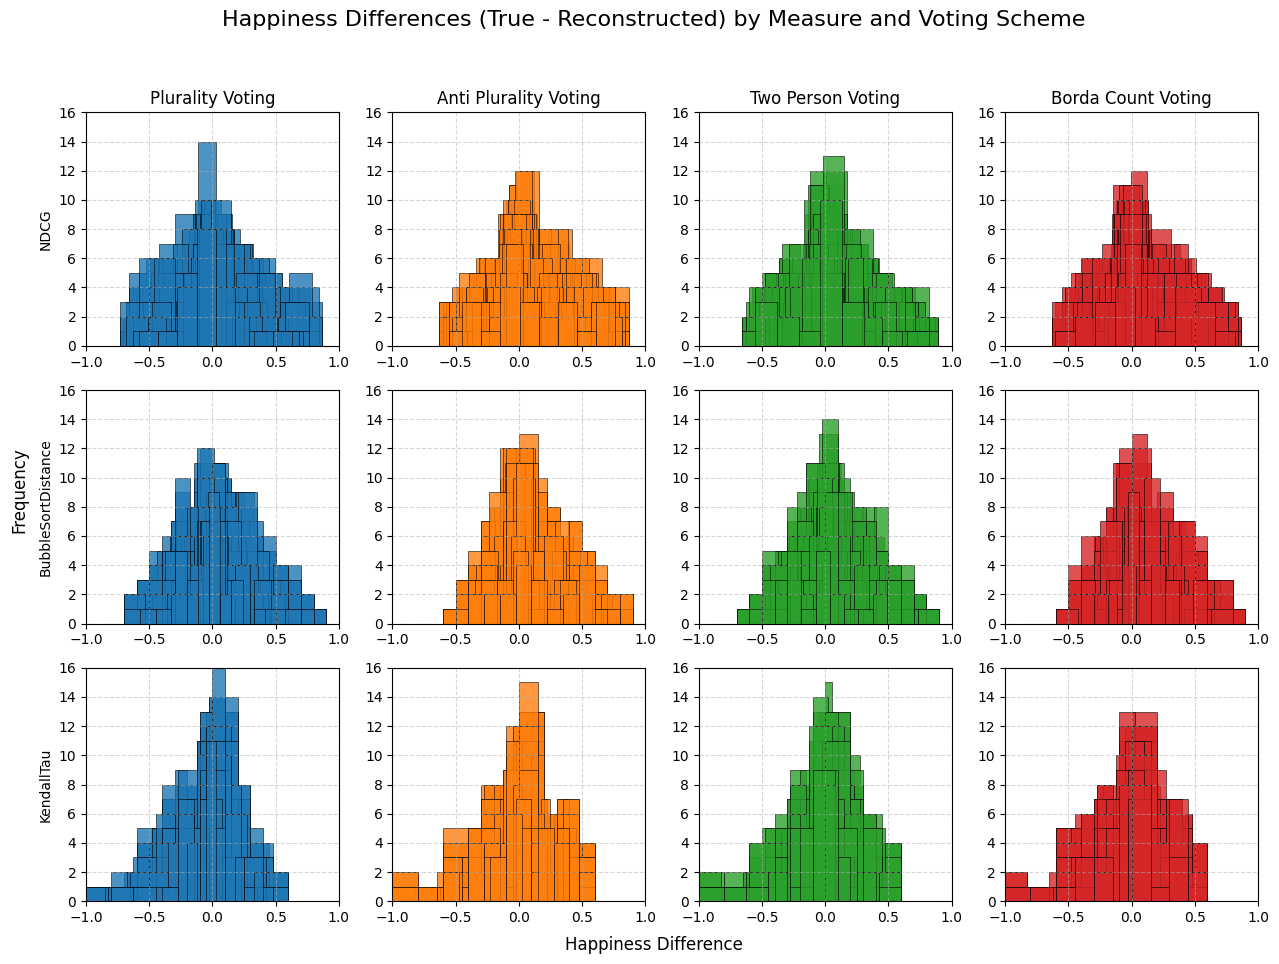

In [ ]:
fig = plt.figure(figsize=(14, 10))

# Define specific colors for your four voting schemes
voting_schemes = ["Plurality Voting", "Anti Plurality Voting", "Two Person Voting", "Borda Count Voting"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # distinct colors
color_map = {scheme: colors[i] for i, scheme in enumerate(voting_schemes)}

# Create separate subplots for each happiness measure AND voting scheme
for i, measure in enumerate(happiness_measures):
    for j, voting_scheme in enumerate(voting_schemes):

        plt.subplot(len(happiness_measures), len(voting_schemes), i*len(voting_schemes) + j + 1)
        plt.xlim((-1,1))
        plt.ylim((0,16))
        
        # Filter for current happiness measure and voting scheme
        filtered_rows = [row for idx, row in experiments_df.iterrows() 
                         if row['happiness_measure'] == measure.__name__ and row['voting_scheme'] == voting_scheme]
        
        if not filtered_rows:
            plt.text(0.5, 0.5, "No data", ha='center', va='center')
            plt.title(f"{voting_scheme}")
            continue
            
        
        # Process each matching row
        for row in filtered_rows:
            reconstruct_preference = row['reconstruct_preference']
            true_outcome = {k: v for k, v in sorted(row['true_outcome'].items(), key=lambda item: item[1], reverse=True)}
            
            reconstruct_happiness = [measure(reconstruct_preference[:,i], list(true_outcome.keys())) for i in range(n)]
            true_happiness = [measure(voter_preference[:,i], list(true_outcome.keys())) for i in range(n)]
            
            # Calculate differences
            differences = [true_happiness[i] - reconstruct_happiness[i] for i in range(len(true_happiness))]
            
            # Create histogram with specific color for this voting scheme
            plt.hist(differences, alpha=0.8, color=color_map[voting_scheme], 
                    bins=8, edgecolor='black', linewidth=0.5)
            
            # Add mean line
            mean_diff = np.mean(differences)
            #plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=1)
            #plt.text(mean_diff, plt.ylim()[1]*0.9, f'Mean: {mean_diff:.2f}', ha='center', va='center', backgroundcolor="white", fontsize=8)
        
        # Set titles and labels
        if j == 0:  # Only add y-label on first column
            plt.ylabel(f'{measure.__name__}')
        if i == 0:  # Only add title on first row
            plt.title(f"{voting_scheme}")
        
        plt.grid(True, linestyle='--', alpha=0.5)

# Add a super title
plt.suptitle('Happiness Differences (True - Reconstructed) by Measure and Voting Scheme', fontsize=16)
fig.text(0.5, 0.04, 'Happiness Difference', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
#plt.savefig(f'happiness_difference_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

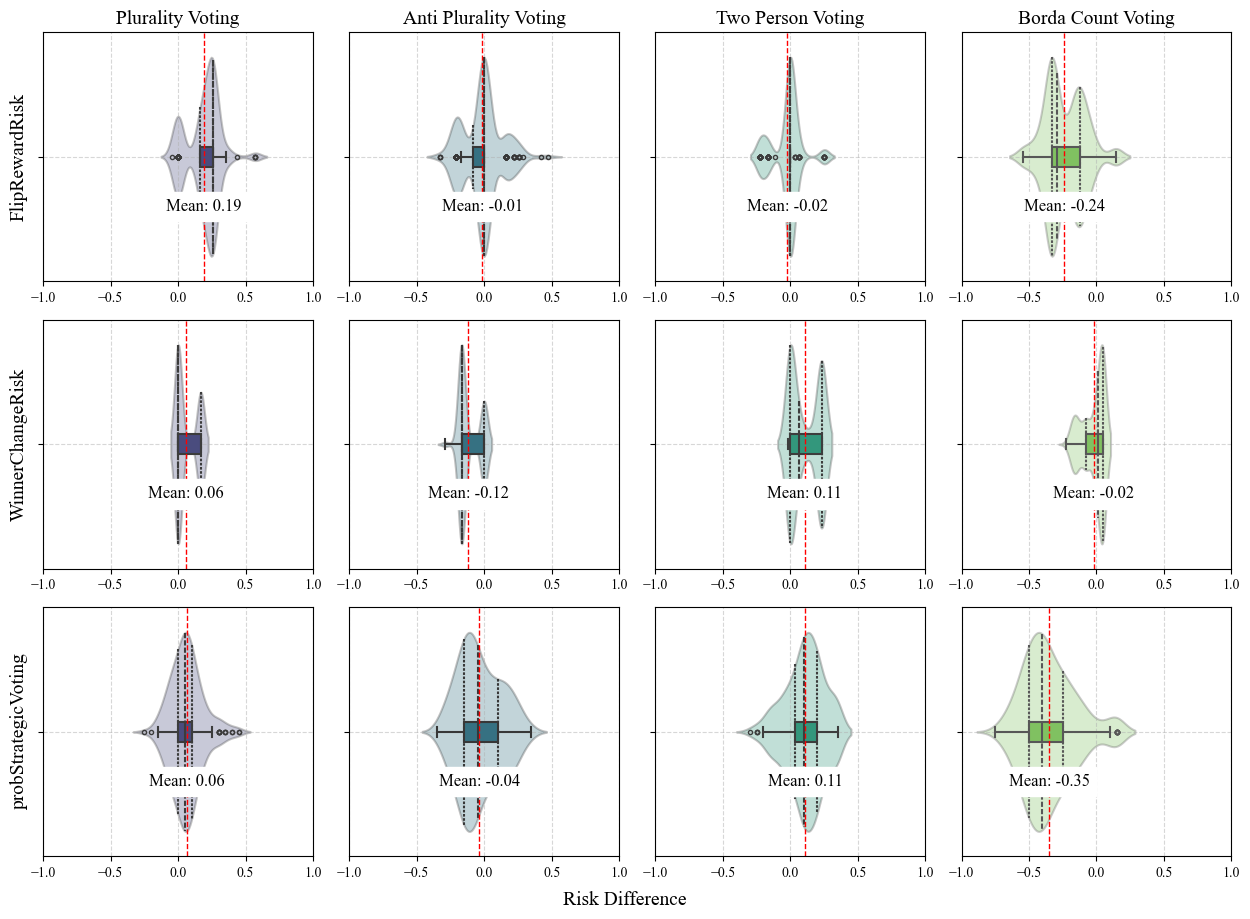

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(figsize=(14, 10))

# Define specific colors for your four voting schemes
voting_schemes = ["Plurality Voting", "Anti Plurality Voting", "Two Person Voting", "Borda Count Voting"]
scientific_colors = sns.color_palette("viridis", 4)  # "mako", "cividis", or "rocket" are also good
color_map = {scheme: scientific_colors[i] for i, scheme in enumerate(voting_schemes)}

# Create subplots for each risk measure and voting scheme
test = 'NDCG'
for i, measure in enumerate(risk_measures):
    for j, voting_scheme in enumerate(voting_schemes):
        plt.subplot(len(risk_measures), len(voting_schemes), i * len(voting_schemes) + j + 1)
        
        # Filter for current risk measure and voting scheme
        filtered_rows = [
            row for idx, row in experiments_df.iterrows()
            if row['risk_measure'] == measure.__name__ and row['voting_scheme'] == voting_scheme and row['happiness_measure'] == test
        ]

        if not filtered_rows:
            plt.text(0, 0, "No data", ha='center', va='center')
            plt.title(f"{voting_scheme}", fontsize=14)
            continue
        
        # Process each matching row
        all_differences = []
        for row in filtered_rows:
            risk_name = measure.__name__
            true_risk = risks[risk_name][test][voting_scheme]
            reconstruct_risk = row['risk']

            # Calculate risk differences
            differences = true_risk - reconstruct_risk
            all_differences.append(differences)

        # Convert to numpy array for better handling
        all_differences = np.array(all_differences)

        # Create violin plot using Seaborn
        sns.violinplot(x=all_differences, color=color_map[voting_scheme], inner="quartile", fill=True, alpha=0.3, linewidth=1.5)
        sns.boxplot(x=all_differences, color=color_map[voting_scheme], width=0.08, fliersize=3, linewidth=1.5)

        # Add mean line
        mean_diff = np.mean(all_differences)
        plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=1)
        plt.text(mean_diff, 0.2, f'Mean: {mean_diff:.2f}', ha='center', va='center', backgroundcolor="white", fontsize=12)

        # Labels and Titles
        if j == 0:  # Only add y-label on first column
            plt.ylabel(f'{measure.__name__}', fontsize=14)
        if i == 0:  # Only add title on first row
            plt.title(f"{voting_scheme}", fontsize=14)

        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xlim((-1,1))

# Add a super title
fig.text(0.5, 0.04, 'Risk Difference', ha='center', fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()

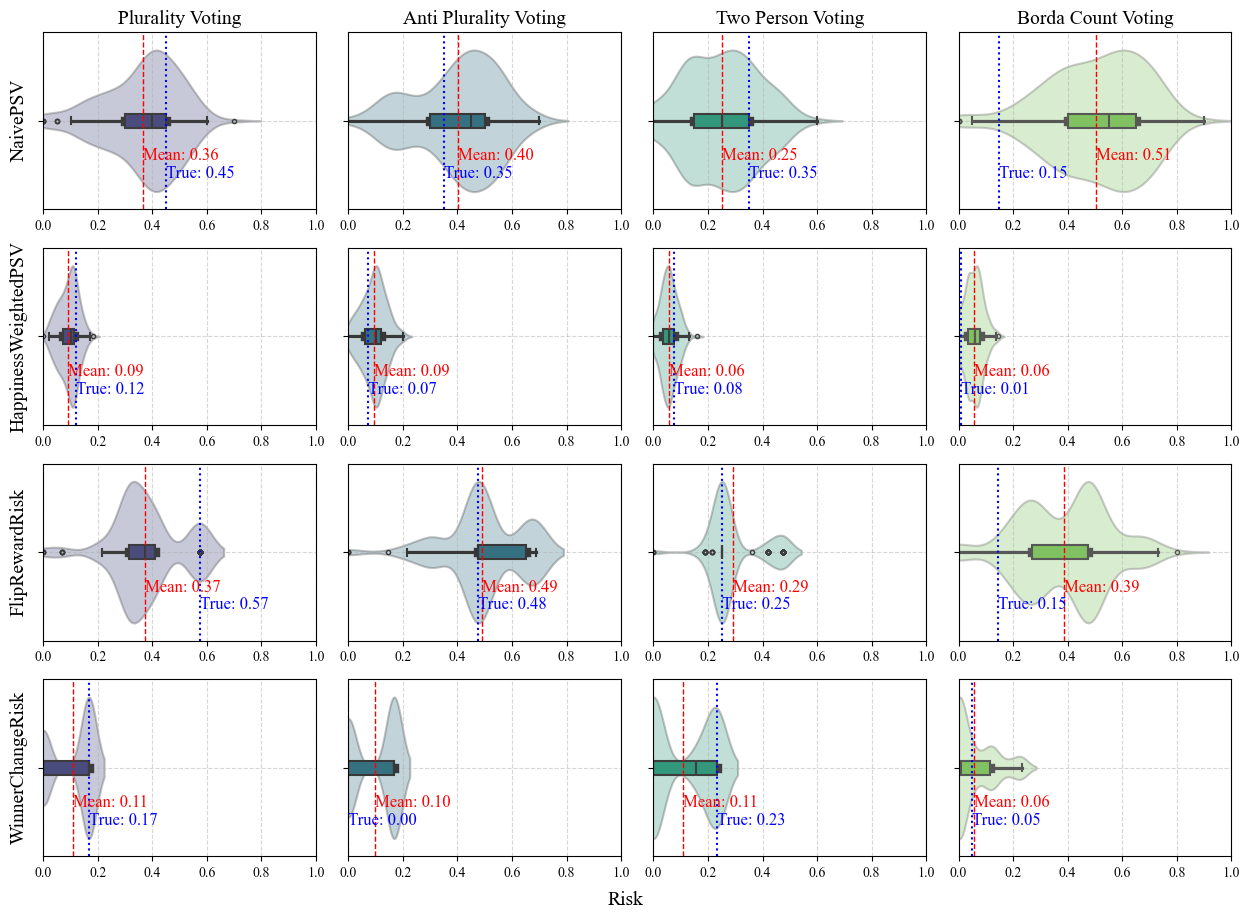

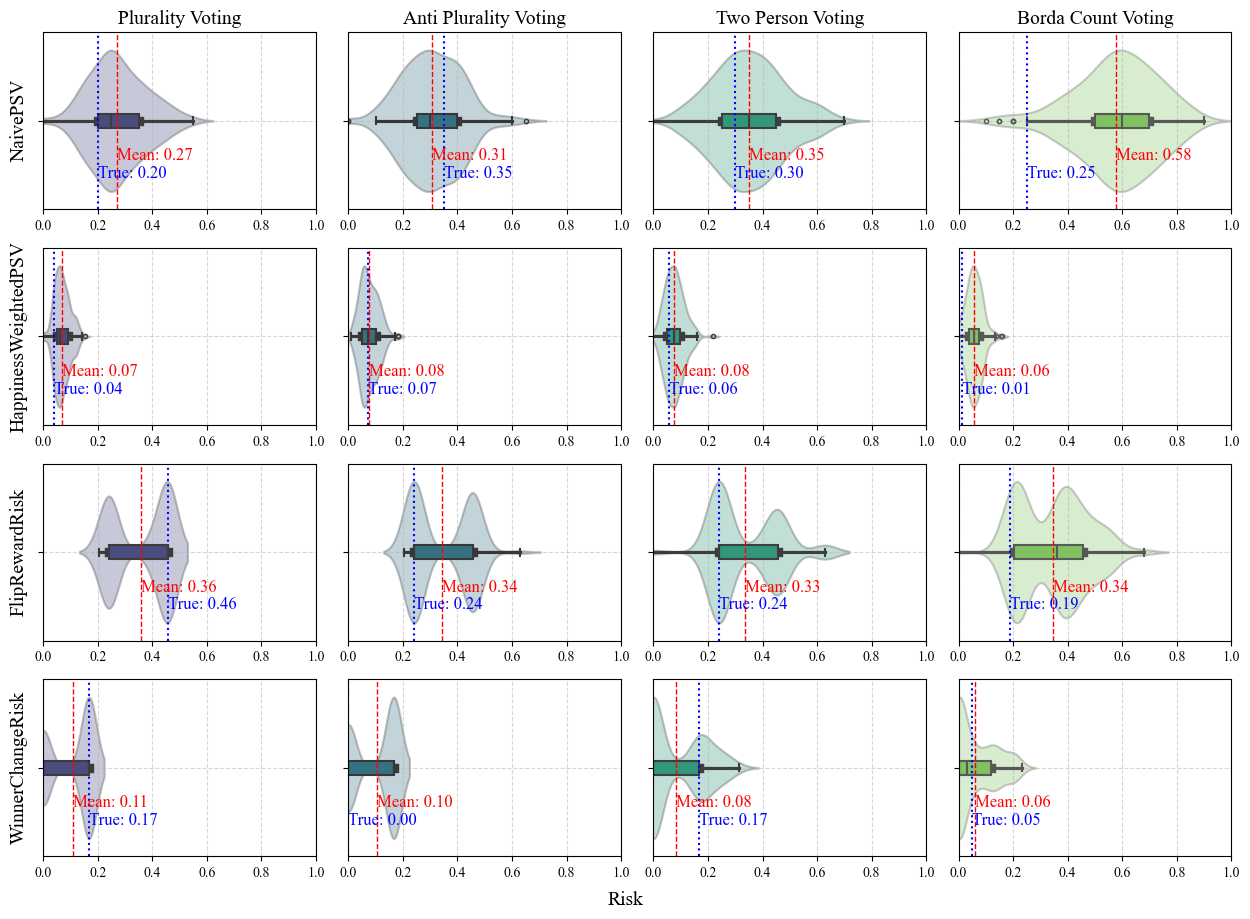

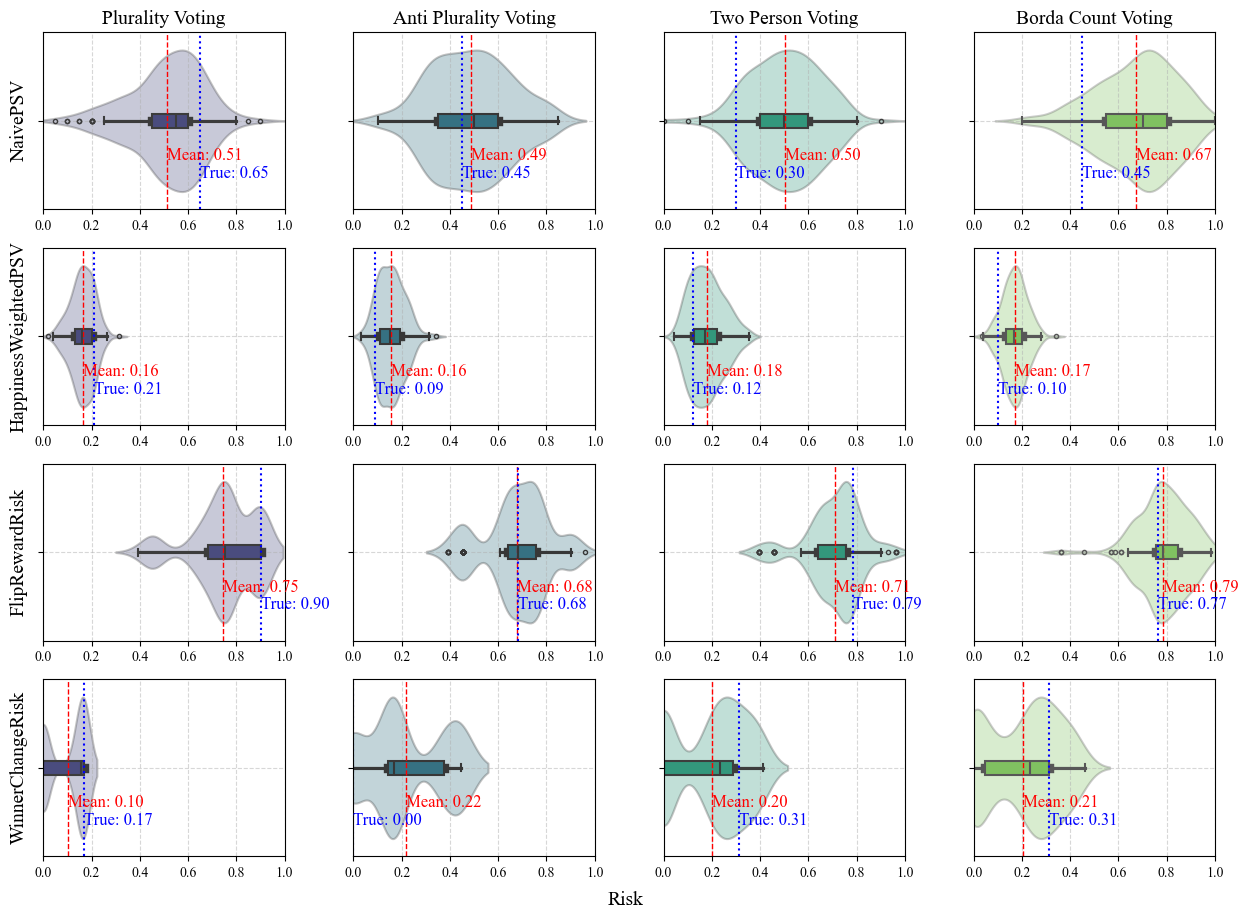

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for test in ['NDCG', 'BubbleSortDistance', 'KendallTau']:
    plt.rcParams['font.family'] = 'Times New Roman'
    fig = plt.figure(figsize=(14, 10))

    # Define specific colors for your four voting schemes
    voting_schemes = ["Plurality Voting", "Anti Plurality Voting", "Two Person Voting", "Borda Count Voting"]
    scientific_colors = sns.color_palette("viridis", 4)  # "mako", "cividis", or "rocket" are also good
    color_map = {scheme: scientific_colors[i] for i, scheme in enumerate(voting_schemes)}

    # Create subplots for each risk measure and voting scheme
    for i, measure in enumerate(risk_measures):
        for j, voting_scheme in enumerate(voting_schemes):
            plt.subplot(len(risk_measures), len(voting_schemes), i * len(voting_schemes) + j + 1)
            
            # Filter for current risk measure and voting scheme
            filtered_rows = [
                row for idx, row in experiments_df.iterrows()
                if row['risk_measure'] == measure.__name__ and row['voting_scheme'] == voting_scheme and row['happiness_measure'] == test
            ]

            if not filtered_rows:
                plt.text(0, 0, "No data", ha='center', va='center')
                plt.title(f"{voting_scheme}", fontsize=14)
                continue
            
            # Process each matching row
            true_risk = risks[measure.__name__][test][voting_scheme]
            reconstruct_risks = [row['risk'] for row in filtered_rows]

            # Convert to numpy array for better handling
            reconstruct_risks = np.array(reconstruct_risks)

            # Create violin plot using Seaborn
            sns.violinplot(x=reconstruct_risks, color=color_map[voting_scheme], fill=True, alpha=0.3, linewidth=1.5) # inner="quartile",
            sns.boxplot(x=reconstruct_risks, color=color_map[voting_scheme], width=0.08, fliersize=3, linewidth=1.5)

            # Add mean line
            mean_risk = np.mean(reconstruct_risks)
            plt.axvline(mean_risk, color='red', linestyle='dashed', linewidth=1)
            plt.text(mean_risk, 0.2, f'Mean: {mean_risk:.2f}', ha='left', va='center', backgroundcolor="white", fontsize=12, color='red', bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))

            # Add true_risk line
            plt.axvline(true_risk, color='blue', linestyle='dotted', linewidth=1.5)
            plt.text(true_risk, 0.3, f'True: {true_risk:.2f}', ha='left', va='center', backgroundcolor="white", fontsize=12, color='blue', bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))

            # Labels and Titles
            if j == 0:  # Only add y-label on first column
                plt.ylabel(f'{measure.__name__}', fontsize=14)
            if i == 0:  # Only add title on first row
                plt.title(f"{voting_scheme}", fontsize=14)

            plt.grid(True, linestyle='--', alpha=0.5)
            plt.xlim((0, 1.0))

    # Add a super title
    fig.text(0.5, 0.04, 'Risk', ha='center', fontsize=14)

    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    plt.show()